In [1]:
%reset -f

# install segmentation models
! pip install segmentation_models -q --user

In [1]:
%matplotlib inline
import gc
import os
import segmentation_models as sm
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import models, layers
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

import logging
logging.getLogger('tensorflow').disabled = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
D:\E\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\E\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\E\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\E\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1

Segmentation Models: using `keras` framework.
Tensorflow version 1.13.1


In [2]:
#Initialize all necessary global variables
img_size=512
repeat_epoch=10
backbone = 'efficientnetb2' 
zoom_pixel_fixed = img_size//4
global TL_FLAG
 
radiopedia_FLAG=0
batch_size = 8
print('batch size', batch_size)
print('zoom_pixel_fixed.........', zoom_pixel_fixed)

batch size 8
zoom_pixel_fixed......... 128


In [3]:
# load the data

prefix = 'D:/E/Project/Bakul Gohel Sir/covid-segmentation/'
if radiopedia_FLAG:
    images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
    masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
    
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)

In [4]:
# normalize the data between 0 and 255
def preprocess_images(images_arr, all_equal=True):
    global max_val, min_val
    if all_equal:
        images_arr = (images_arr-min_val)/(max_val-min_val)

    images_arr = images_arr*255
    mins = images_arr.min()
    maxs = images_arr.max()
    print(f'After normalization mins {mins}, maxs {maxs}')
    return images_arr, (mins, maxs)

# initalize max and min values
global max_val
global min_val
max_val = images_medseg.max()
min_val = images_medseg.min()
print('images_medseg_max {}, images_medseg_min {}'.format(images_medseg.max(), images_medseg.min()))
print('mask_medseg_max {}, mask_medseg_min {}'.format(masks_medseg.max(), masks_medseg.min()))
print('image_medseg_shape {}, mask_medseg_shape {}'.format(images_medseg.shape, masks_medseg.shape))

# normalize them now
if radiopedia_FLAG:
    images_radiopedia, _ = preprocess_images(images_radiopedia) 
images_medseg, _ = preprocess_images(images_medseg)

images_medseg_max 597.8046875, images_medseg_min -1606.521728515625
mask_medseg_max 1, mask_medseg_min 0
image_medseg_shape (100, 512, 512, 1), mask_medseg_shape (100, 512, 512, 4)
After normalization mins 0.0, maxs 255.0


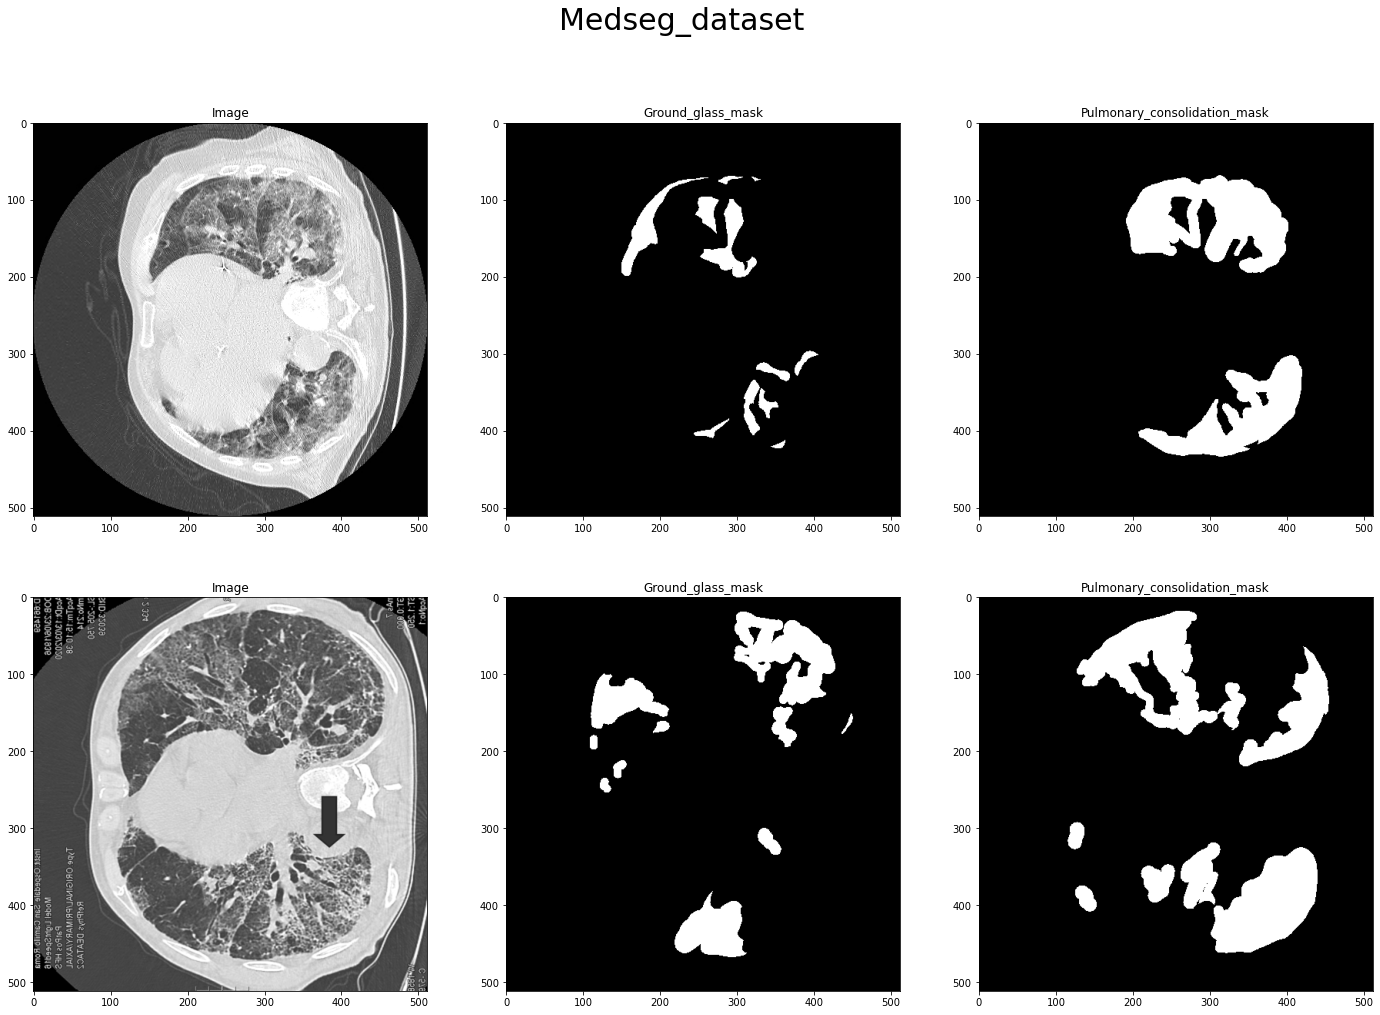

In [5]:
# plot with only 3 columns

def plot_images(data, col = 3, colour_map = 'gray', img_size=8, title = 'Medseg_dataset',
                sub_title = ['Image', 'Ground_glass_mask', 'Pulmonary_consolidation_mask']):
    if len(data)%col ==0:
        rows = (len(data)//col)
    else:
        rows = (len(data)//col)+1
    fig = plt.figure(figsize=(col*img_size, rows*img_size))
    plt.suptitle(title, fontsize = 30)        
    for i, image_ in enumerate(data):
        fig.add_subplot(rows, col, i+1)
        plt.imshow(data[i], cmap=colour_map)
        plt.title(sub_title[i%col])
    plt.show()
    

# plot few Medseg_images and corresponding Masks
    
plot_list = []    
for i in range(2):
    plot_list.append(images_medseg[i].reshape(512,512))
    plot_list.append((masks_medseg[i][..., 0]*255).reshape(512,512))  # scale images between 0 and 255
    plot_list.append((masks_medseg[i][..., 1]*255).reshape(512,512))   # scale images between 0 and 255  

plot_images(plot_list)

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('D:/E/Project/Bakul Gohel Sir'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:/E/Project/Bakul Gohel Sir\Covid-19 ESPCN.ipynb
D:/E/Project/Bakul Gohel Sir\covid-segmentation.zip
D:/E/Project/Bakul Gohel Sir\TF-ESPCN-master.zip
D:/E/Project/Bakul Gohel Sir\covid-segmentation\images_medseg.npy
D:/E/Project/Bakul Gohel Sir\covid-segmentation\images_radiopedia.npy
D:/E/Project/Bakul Gohel Sir\covid-segmentation\masks_medseg.npy
D:/E/Project/Bakul Gohel Sir\covid-segmentation\masks_radiopedia.npy
D:/E/Project/Bakul Gohel Sir\covid-segmentation\test_images_medseg.npy
D:/E/Project/Bakul Gohel Sir\covid-segmentation\upscaled.png
D:/E/Project/Bakul Gohel Sir\covid-segmentation\ESPCN\espcn102.png
D:/E/Project/Bakul Gohel Sir\covid-segmentation\ESPCN\espcn103.png
D:/E/Project/Bakul Gohel Sir\covid-segmentation\ESPCN\espcn104.png
D:/E/Project/Bakul Gohel Sir\covid-segmentation\ESPCN\espcn105.png
D:/E/Project/Bakul Gohel Sir\covid-segmentation\ESPCN\espcn106.png
D:/E/Project/Bakul Gohel Sir\covid-segmentation\ESPCN\espcn107.png
D:/E/Project/Bakul Gohel Sir\covid-segmentati

In [7]:
prefix = 'D:/E/Project/Bakul Gohel Sir/covid-segmentation/'

images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)

test_images_medseg = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)

In [8]:
print(masks_medseg.shape)

(100, 512, 512, 4)


In [9]:
import matplotlib.pyplot as plt
import numpy as np


def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

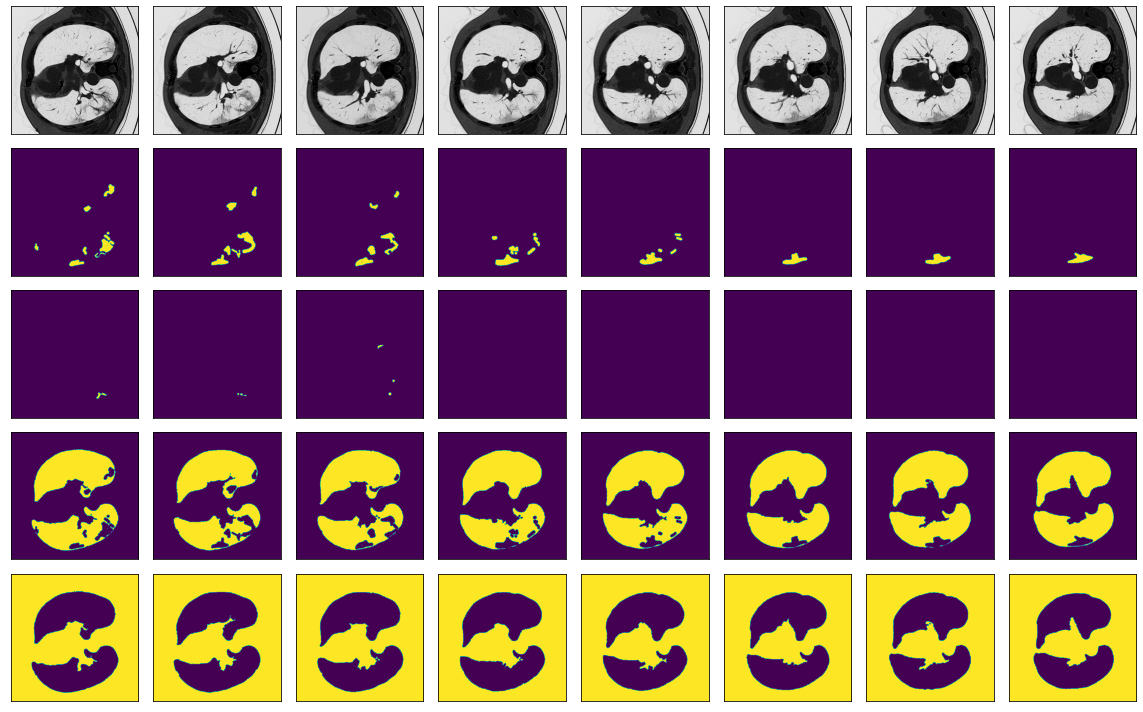

In [10]:
visualize(images_radiopedia[30:], masks_radiopedia[30:])

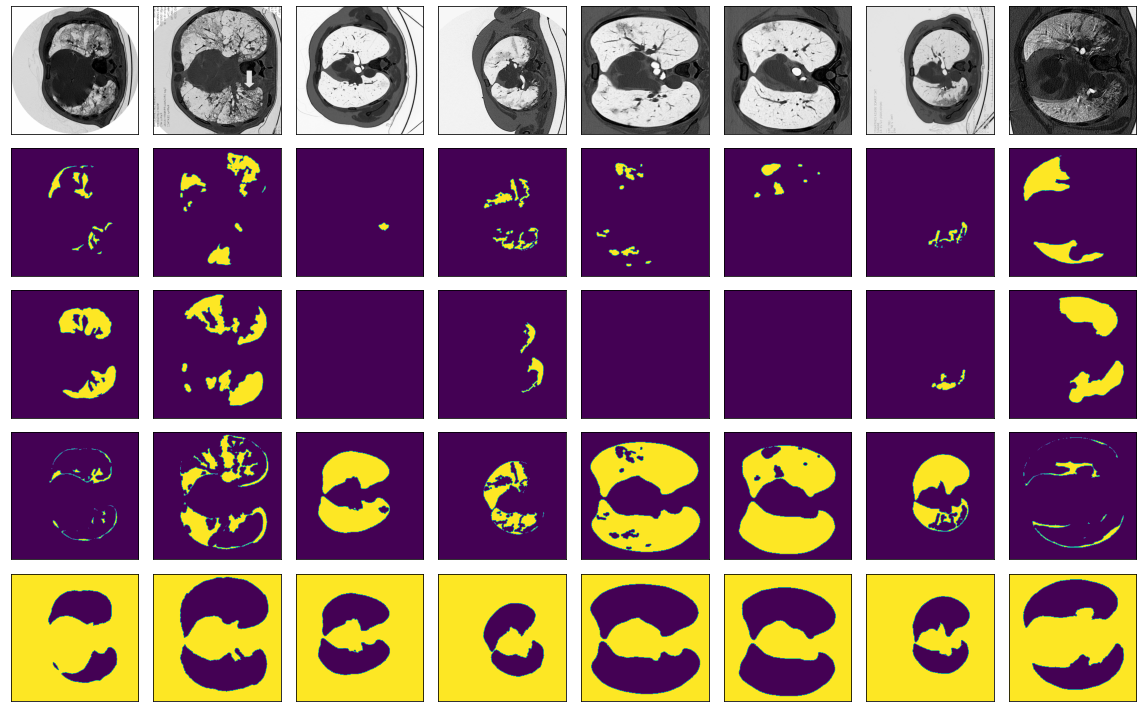

In [11]:
visualize(images_medseg, masks_medseg)

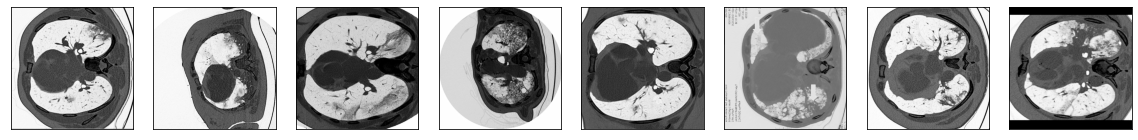

In [12]:
visualize(test_images_medseg)

In [13]:
cv2.__version__

'4.3.0'

In [14]:
print(cv2.__file__)

D:\E\anaconda\lib\site-packages\cv2.cp37-win_amd64.pyd


In [15]:
# -*- coding: utf-8 -*-
"""
Created on Fri Mar 11 16:50:50 2022

@author: admin
"""
#import nrrd
import scipy.ndimage as ndimage
from skimage.metrics import structural_similarity
from skimage.transform import resize
import nibabel

#img_file='E:\\DAIICT_RESEARCH\HISTOPATHO\\DATABASES\\HistpPatho\\ICIAR2018_DATASET\\ICIAR2018_BACH_Challenge\\ICIAR2018_BACH_Challenge\\Photos\\Benign\\Lung4.jpg'


#D_HR = cv2.imread(img_file, 0)

#D_HR = np.asanyarray(D_HR, dtype=float)
#D_HR = (D_HR - np.mean(D_HR))/np.std(D_HR )

"""

file = 'E:\\DAIICT_RESEARCH\\BioMedImaging\\DATASETS\\Medseg_COVID19_v1\\tr_im.nii'
img = nibabel.load(file)
img = img.get_data()
img = np.asarray(img, dtype=np.uint16)
"""
img= images_medseg
SSIM_ALL = np.zeros((100))
#print(img.shape)
for i in range(0,100):
    D_HR = np.squeeze(img[i,:,:])
    #print(D_HR.shape, D_HR.dtype)
   
    D_LR = D_HR[::4,::4]
    #print(D_LR.shape)
    D_SR = cv2.resize(D_LR, dsize=(D_HR.shape[1],D_HR.shape[0]), interpolation=cv2.INTER_CUBIC)
    #D_SR = D_SR[:,:,0]
    #print(D_SR.shape,D_SR.dtype)
    ssim, ssim_map = structural_similarity(D_SR, D_HR, full=True, data_range=(np.max(D_HR)-np.min(D_HR)))
    SSIM_ALL[i] = ssim
    print(i,':', ssim)
   
print(np.mean(SSIM_ALL))
print(np.std(SSIM_ALL))

0 : 0.4406715427729415
1 : 0.4809457913494431
2 : 0.66659745697282
3 : 0.19475432294400652
4 : 0.5636672934820613
5 : 0.5500284543508428
6 : 0.6649015912204463
7 : 0.2208164090374583
8 : 0.5419706551726841
9 : 0.36209840006875776
10 : 0.40083654462667684
11 : 0.6606211216579592
12 : 0.1997696757574764
13 : 0.592690604716095
14 : 0.27213578741920297
15 : 0.4974343189343961
16 : 0.5462118040034574
17 : 0.5498084812557851
18 : 0.41687373848236986
19 : 0.6074934548036379
20 : 0.4527590726391706
21 : 0.5582548599259775
22 : 0.6718202750053427
23 : 0.6061587067107705
24 : 0.254822950746172
25 : 0.7230652344441281
26 : 0.6568052169159757
27 : 0.6598530171911399
28 : 0.19118009587257948
29 : 0.5616279392444432
30 : 0.7277836946217231
31 : 0.5633007742174322
32 : 0.7135801881424417
33 : 0.5941560538406073
34 : 0.7426314976567988
35 : 0.5756905574689706
36 : 0.23234340934954822
37 : 0.5582266413094767
38 : 0.49953678907055044
39 : 0.6872902314717144
40 : 0.3952859918066588
41 : 0.528899086842969

In [16]:
img= images_medseg
SSIM_ALL = np.zeros((100))
#print(img.shape)
for i in range(0,100):
    D_HR = np.squeeze(img[i,:,:])
    #print(D_HR.shape, D_HR.dtype)
   
    D_LR = D_HR[::4,::4]
    #print(D_LR.shape)
    D_SR = cv2.resize(D_LR, dsize=(D_HR.shape[1],D_HR.shape[0]), interpolation=cv2.INTER_CUBIC)
    #D_SR = D_SR[:,:,0]
    #print(D_SR.shape,D_SR.dtype)
    ssim, ssim_map = structural_similarity(D_SR, D_HR, full=True, data_range=(np.max(D_HR)-np.min(D_HR)))
    SSIM_ALL[i] = ssim
    print(i,':', ssim)
   
print(np.mean(SSIM_ALL))
print(np.std(SSIM_ALL))

0 : 0.4406715427729415
1 : 0.4809457913494431
2 : 0.66659745697282
3 : 0.19475432294400652
4 : 0.5636672934820613
5 : 0.5500284543508428
6 : 0.6649015912204463
7 : 0.2208164090374583
8 : 0.5419706551726841
9 : 0.36209840006875776
10 : 0.40083654462667684
11 : 0.6606211216579592
12 : 0.1997696757574764
13 : 0.592690604716095
14 : 0.27213578741920297
15 : 0.4974343189343961
16 : 0.5462118040034574
17 : 0.5498084812557851
18 : 0.41687373848236986
19 : 0.6074934548036379
20 : 0.4527590726391706
21 : 0.5582548599259775
22 : 0.6718202750053427
23 : 0.6061587067107705
24 : 0.254822950746172
25 : 0.7230652344441281
26 : 0.6568052169159757
27 : 0.6598530171911399
28 : 0.19118009587257948
29 : 0.5616279392444432
30 : 0.7277836946217231
31 : 0.5633007742174322
32 : 0.7135801881424417
33 : 0.5941560538406073
34 : 0.7426314976567988
35 : 0.5756905574689706
36 : 0.23234340934954822
37 : 0.5582266413094767
38 : 0.49953678907055044
39 : 0.6872902314717144
40 : 0.3952859918066588
41 : 0.528899086842969

In [21]:
from cv2 import dnn_superres

# Create an SR object
sr = cv2.dnn_superres.DnnSuperResImpl_create()

img= images_radiopedia
SSIM_ALL = np.zeros((100))
count=0
#print(img.shape)
for i in range(0,100):
    D_HR = np.squeeze(img[i,:,:])
    D_mask = np.squeeze(masks_radiopedia[i,:,:,3])
    D_mask = (D_mask==0)
    #print((D_HR*D_mask).min(), (D_HR*D_mask).max())
    #print(D_HR.shape, D_HR.dtype)
   
    D_LR = D_HR[::2,::2]
    #print(D_LR.shape)
    D_SR = cv2.resize(D_LR, dsize=(D_HR.shape[1],D_HR.shape[0]), interpolation=cv2.INTER_CUBIC)
    #D_SR = D_SR[:,:,0]
    #print(D_SR.shape,D_SR.dtype)
    ssim, ssim_map = structural_similarity(D_SR, D_HR, full=True, window=11, data_range=1600)
    SSIM_ALL[i] = np.sum(ssim_map*D_mask)/np.sum(D_mask)
    print(i,':', ssim)
    
    
    # Read the desired model
    path = "D:\E\Project\Bakul Gohel Sir\TF-ESPCN-master\TF-ESPCN-master\export\ESPCN_x4.pb"
    sr.readModel(path)

    # Set the desired model and scale to get correct pre- and post-processing
    sr.setModel("espcn", 4)
    count=count+1
    count=str(count)
    # Upscale the image
    result = sr.upsample(D_LR)
    new_dir=dir+"espcn"+count+".png"
    count=int(count)
    # Save the image
    cv2.imwrite(new_dir, result)
   
print(np.mean(SSIM_ALL))
print(np.std(SSIM_ALL))

0 : 0.6128147574030837


TypeError: unsupported operand type(s) for +: 'builtin_function_or_method' and 'str'

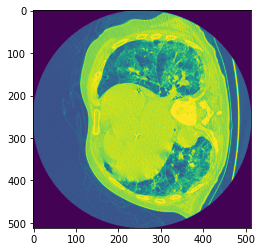

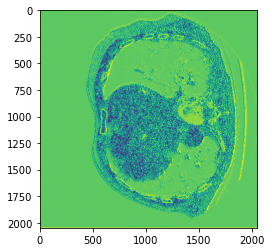

In [22]:
import cv2
from cv2 import dnn_superres

# Create an SR object
sr = cv2.dnn_superres.DnnSuperResImpl_create()

# Read image
image = images_medseg[0]
plt.imshow(image)
plt.show()

# Read the desired model
path = "D:\E\Project\Bakul Gohel Sir\TF-ESPCN-master\TF-ESPCN-master\export\ESPCN_x4.pb"
sr.readModel(path)

# Set the desired model and scale to get correct pre- and post-processing
sr.setModel("espcn", 4)

# Upscale the image
result = sr.upsample(image)

# Save the image
cv2.imwrite("D:/E/Project/Bakul Gohel Sir/covid-segmentation/upscaled.png", result)
plt.imshow(result)
plt.show()

In [24]:
!pip install --user --upgrade tensorflow-model-optimization

In [26]:
!pip install tensorflow

In [27]:
from tensorflow.keras.layers import  Input, Conv2D, Lambda
from tensorflow.keras.models import Model,load_model
import tensorflow as tf
import tensorflow_model_optimization as tfmot

ImportError: This version of TensorFlow Model Optimization requires TensorFlow version >= 1.14.0; Detected an installation of version 1.13.1. Please upgrade TensorFlow to proceed.